## Set-up

In [11]:
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch.nn.functional as F  # Import F for softmax
import torch.optim as optim
from PIL import Image, ImageFile
import os
import numpy as np
from tqdm.notebook import tqdm
import json
import matplotlib.pyplot as plt
from IPython.display import display  # Import display module

In [12]:
# Parameters
identifier = 'softmax-v02'
class_names = ['Boston', 'Charlotte', 'Manhattan', 'Pittsburgh']
folders = {
    'Boston': '../data/ma-boston/buildings',
    'Charlotte': '../data/nc-charlotte/buildings',
    'Manhattan': '../data/ny-manhattan/buildings',
    'Pittsburgh': '../data/pa-pittsburgh/buildings'
}
output_folder = 'softmax-output'
normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]
batch_size = 128
num_classes = len(class_names)
train_split_ratio = 0.8
num_epochs = 10
learning_rate = 0.001
checkpoint_interval = 1
checkpoint_dir = os.path.join(output_folder, f'checkpoints-{identifier}')
model_save_path = os.path.join(output_folder, f'trained-model-{identifier}.pth')
loss_log_path = os.path.join(output_folder, f'loss-log-{identifier}.json')
training_params_path = os.path.join(output_folder, f'training-params-{identifier}.json')
feature_file_name = f'city-features-{identifier}.npy'
new_image_path = '../data/ny-brooklyn/buildings/buildings_1370.jpg' # test an image
predictions_output_file = os.path.join(output_folder, f'predictions-{identifier}.txt')

# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Define output folder
os.makedirs(output_folder, exist_ok=True)

## Extract and save features

In [ ]:
# Define a custom dataset class
class CityDataset(Dataset):
    def __init__(self, folders, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(folders.keys())}

        for class_name, folder in folders.items():
            for filename in os.listdir(folder):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    self.image_paths.append(os.path.join(folder, filename))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image, label

# Create dataset
dataset = CityDataset(folders)

# Automatically detect the input image size
first_image_path = dataset.image_paths[0]
first_image = Image.open(first_image_path)
image_size = first_image.size  # (width, height)

# Define transformations: resize, convert to tensor, normalize
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=normalize_mean, std=normalize_std),
])

# Update dataset with transform
dataset.transform = transform
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Load a pre-trained ResNet50 model using the 'weights' parameter
weights = models.ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights)

# Modify the final layer to match the number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Set device to MPS if available, otherwise fall back to CUDA or CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

model.to(device)

# Save model outputs as features
def extract_and_save_features(model, data_loader, file_name):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, label in tqdm(data_loader, desc="Extracting features", leave=False):
            images = images.to(device)
            outputs = model(images)
            features.append(outputs.cpu().numpy())
            labels.append(label.numpy())
    
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    np.save(os.path.join(output_folder, file_name), {'features': features, 'labels': labels})

# Extract and save features
extract_and_save_features(model, data_loader, feature_file_name)

### Model training

In [ ]:
# Model training
def train_and_save_model(model, train_loader, num_epochs, checkpoint_interval, checkpoint_dir):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_log = []

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            progress_bar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        loss_log.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

        # Save checkpoint
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth')
            os.makedirs(checkpoint_dir, exist_ok=True)
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Checkpoint saved at {checkpoint_path}')

    # Save the final model weights
    torch.save(model.state_dict(), model_save_path)

    # Save the loss log
    with open(loss_log_path, 'w') as f:
        json.dump(loss_log, f)

    # Save the training parameters and plot
    training_params = {
        'num_epochs': num_epochs,
        'learning_rate': learning_rate,
        'checkpoint_interval': checkpoint_interval,
        'batch_size': train_loader.batch_size,
        'identifier': identifier
    }
    with open(training_params_path, 'w') as f:
        json.dump(training_params, f)

    # Plot the loss log
    plt.figure()
    plt.plot(range(1, num_epochs + 1), loss_log, marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig(os.path.join(output_folder, f'training_loss_plot-{identifier}.png'))
    plt.close()

# Train and save the model
train_size = int(train_split_ratio * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

train_and_save_model(model, train_loader, num_epochs, checkpoint_interval, checkpoint_dir)

### Classification

Classifying new image:   0%|          | 0/1 [00:00<?, ?it/s]

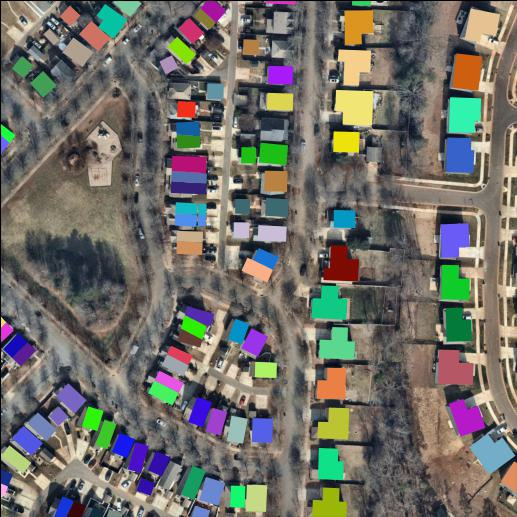

Predicted class: CityB, Confidence: 100.00%
Predicted class: CityD, Confidence: 0.00%
Predicted class: CityC, Confidence: 0.00%
Predicted class: CityA, Confidence: 0.00%
Image path: ../data/nc-charlotte/buildings/buildings_131.jpg


In [14]:
# Temp. overwrite: model and new image for testing purposes
model_save_path = 'softmax-output/checkpoints-experiment_01/checkpoint_epoch_2.pth' # overwrite with latest checkpoint while model still trains
new_image_path = '../data/nc-charlotte/buildings/buildings_131.jpg' # overwrite image path

# Load model weights
model.load_state_dict(torch.load(model_save_path, weights_only=True))

# Function to classify a new image
def classify_new_image(image_path, model, transform):
    model.eval()
    input_image = Image.open(image_path)
    input_tensor = transform(input_image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = F.softmax(output, dim=1)
        probabilities = probabilities.cpu().numpy().flatten()

    predictions = [(class_names[i], prob * 100) for i, prob in enumerate(probabilities)]
    predictions.sort(key=lambda x: x[1], reverse=True)
    return predictions, input_image

with tqdm(total=1, desc="Classifying new image", leave=False) as pbar:
    predictions, input_image = classify_new_image(new_image_path, model, transform)
    pbar.update(1)

# Display the image
display(input_image)

# Save predictions to a file
with open(predictions_output_file, 'w') as f:
    f.write(f'Image path: {new_image_path}\n')  # Write the image path
    for label, percentage in predictions:
        f.write(f'Predicted class: {label}, Confidence: {percentage:.2f}%\n')
        print(f'Predicted class: {label}, Confidence: {percentage:.2f}%')

# Optionally, display the predictions in the notebook
print(f'Image path: {new_image_path}')
#for label, percentage in predictions:
#    print(f'Predicted class: {label}, Confidence: {percentage:.2f}%')